In [67]:
!pip install astral


In [93]:
import pandas as pd
df = pd.read_csv(r"C:\Users\Dell\Downloads\electricity-consumption-india-city-level-2017-19.csv")
df.head()


,City,Year,Consumption of Electricity (in lakh units)-Domestic purpose,Consumption of Electricity (in lakh units)-Commercial purpose,Consumption of Electricity (in lakh units)-Industry purpose,Consumption of Electricity (in lakh units)-Public Water Work & Street Light,Consumption of Electricity (in lakh units)-Others,Consumption of Electricity (in lakh units)-Total Consumption
0,Agartala,2018-19,213.98,30.80,5.94,13.13,55.25,319.10
1,Agra,2017-18,9772.00,3811.00,2870.00,583.00,157.00,17191.00
2,Aizawl,2018-19,2386.93,481.15,133.41,437.78,518.55,3957.82
3,Amritsar,2017-18,4076.09,2131.73,1479.03,206.00,166.24,8059.09
4,Aurangabad Maharashtra (Total Consumption/Month),2017-18,275.07,83.97,121.08,18.38,19.12,517.62


Loaded CSV. Columns: ['City', 'Year', 'Consumption of Electricity (in lakh units)-Domestic purpose', 'Consumption of Electricity (in lakh units)-Commercial purpose', 'Consumption of Electricity (in lakh units)-Industry purpose', 'Consumption of Electricity (in lakh units)-Public Water Work & Street Light', 'Consumption of Electricity (in lakh units)-Others', 'Consumption of Electricity (in lakh units)-Total Consumption']
Using columns -> City: City, Year: Year, Total: Consumption of Electricity (in lakh units)-Total Consumption


C:\Users\Dell\AppData\Local\Temp\ipykernel_6208\2479254749.py:163: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hour_index = pd.date_range(start=pd.Timestamp.now().normalize(), periods=hours, freq='H')



Model performance:
R2 = 0.318, MAE = 2,654,852,275 kWh

--- Aggregate ---
Daily saving = 8,869 kWh/day
Annualized saving = 3,237,139 kWh/year
Estimated annual ₹ saving = ₹16,185,697.47
Results saved to city_level_simulation_results.csv



Enter a city to plot (press Enter to use first):  



Plotting for Agartala  (Predicted Total: 454,105,758 kWh)


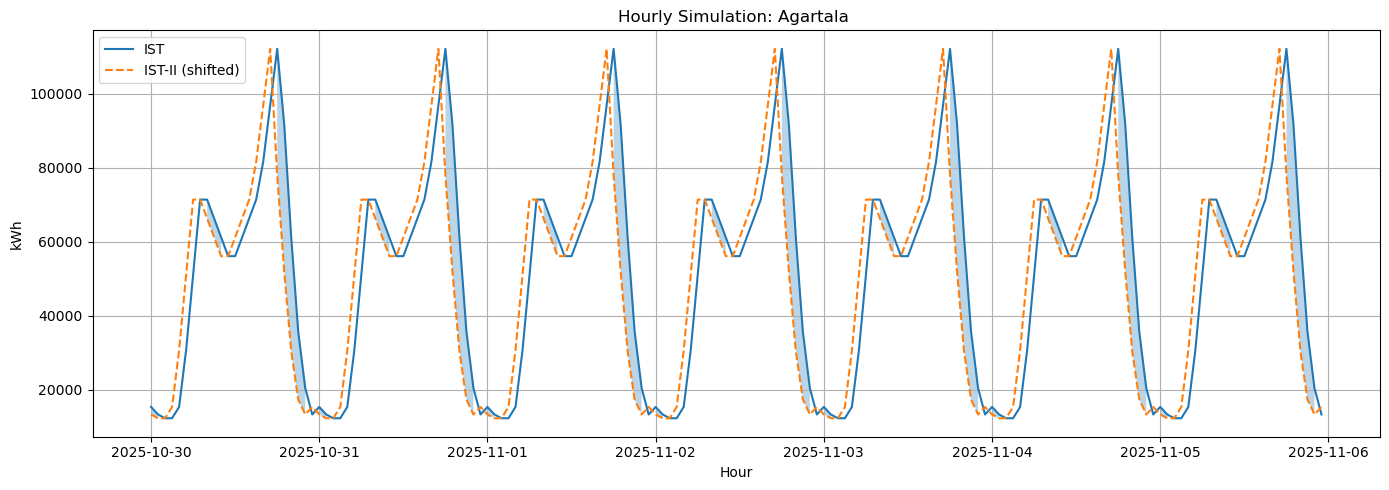

In [1]:

import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error


# USER PARAMETERS

DATA_PATH = r"C:\Users\Dell\Downloads\electricity-consumption-india-city-level-2017-19.csv"
COST_PER_KWH = 5.0
TIME_SHIFT_HOURS = 1.0
PREDICT_DAYS = 7
EVENING_SAVINGS_FACTOR = 0.85
UNIT_MULTIPLIER = 100000.0


# LOAD DATA

if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"File not found: {DATA_PATH}")

raw = pd.read_csv(DATA_PATH)
raw.columns = raw.columns.str.strip()
print("Loaded CSV. Columns:", list(raw.columns))


# FIND RELEVANT COLUMNS

def find_column(cols, keywords):
    cols_lower = [c.lower() for c in cols]
    for kw in keywords:
        for i, cl in enumerate(cols_lower):
            if kw in cl:
                return cols[i]
    return None

city_col = find_column(raw.columns, ["city", "name of city", "location"])
year_col = find_column(raw.columns, ["year"])
total_col = find_column(raw.columns, ["total", "consumption"])

if city_col is None:
    raise KeyError("Could not find City column.")
if total_col is None:
    raise KeyError("Could not find Total Consumption column.")
if year_col is None:
    print("No Year column found, using default year 2019.")
    raw["Year"] = 2019
    year_col = "Year"

print(f"Using columns -> City: {city_col}, Year: {year_col}, Total: {total_col}")


# CLEAN DATA

df = raw[[city_col, year_col, total_col]].copy()
df.columns = ["City", "Year", "TotalConsumptionRaw"]

def clean_year(y):
    try:
        y_str = str(y).strip()
        if "-" in y_str:
            y_str = y_str.split("-")[0]
        return int(y_str)
    except:
        return np.nan

df["Year"] = df["Year"].apply(clean_year)
df.dropna(subset=["Year"], inplace=True)
df["Year"] = df["Year"].astype(int)

def to_number(x):
    try:
        return float(str(x).replace(",", "").strip())
    except:
        return np.nan

df["TotalConsumptionRaw"] = df["TotalConsumptionRaw"].apply(to_number)
df.dropna(subset=["City", "TotalConsumptionRaw"], inplace=True)
df["Total_kWh"] = df["TotalConsumptionRaw"] * UNIT_MULTIPLIER


# CITY COORDINATES

CITY_COORDS = {
    "Mumbai": (19.0760, 72.8777),
    "New Delhi": (28.6139, 77.2090),
    "Delhi": (28.6139, 77.2090),
    "Kolkata": (22.5726, 88.3639),
    "Chennai": (13.0827, 80.2707),
    "Bengaluru": (12.9716, 77.5946),
    "Hyderabad": (17.3850, 78.4867),
    "Ahmedabad": (23.0225, 72.5714),
    "Pune": (18.5204, 73.8567),
    "Jaipur": (26.9124, 75.7873),
    "Lucknow": (26.8467, 80.9462),
}
FALLBACK_LAT, FALLBACK_LON = 22.0, 82.5

def lookup_coords(city_name):
    if pd.isna(city_name):
        return (FALLBACK_LAT, FALLBACK_LON)
    c = str(city_name).strip()
    for k, v in CITY_COORDS.items():
        if k.lower() in c.lower() or c.lower() in k.lower():
            return v
    return (FALLBACK_LAT, FALLBACK_LON)

coords = [lookup_coords(c) for c in df["City"]]
df["Latitude"] = [lat for lat, lon in coords]
df["Longitude"] = [lon for lat, lon in coords]


# COMPUTE DAYLIGHT HOURS

def daylength_for_lat_on_n(lat_deg, n=172):
    decl_deg = 23.44 * math.sin(2 * math.pi * (284 + n) / 365.0)
    decl = math.radians(decl_deg)
    phi = math.radians(lat_deg)
    x = -math.tan(phi) * math.tan(decl)
    x = max(-1.0, min(1.0, x))
    omega0 = math.acos(x)
    return (24.0 / math.pi) * omega0

df["Daylight_Hours"] = df["Latitude"].apply(lambda lat: daylength_for_lat_on_n(lat))
df["TimeMisalign_min"] = df["Longitude"].apply(lambda lon: (lon - 82.5) * 4)
df["LatAbsProxy"] = df["Latitude"].abs()


# MODEL TRAINING

feature_cols = ["Latitude", "Longitude", "Year", "Daylight_Hours", "TimeMisalign_min", "LatAbsProxy"]
X = df[feature_cols].fillna(0.0).astype(float).values
y = df["Total_kWh"].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(n_estimators=300, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("\nModel performance:")
print(f"R2 = {r2_score(y_test, y_pred):.3f}, MAE = {mean_absolute_error(y_test, y_pred):,.0f} kWh")

df["Pred_Total_kWh"] = model.predict(X_scaled)


# SYNTHETIC HOURLY PROFILE

base_profile = np.array([
    0.015,0.013,0.012,0.012,0.015,0.030,0.050,0.070,0.070,0.065,0.060,0.055,
    0.055,0.060,0.065,0.070,0.080,0.095,0.110,0.090,0.060,0.035,0.020,0.013
])
base_profile /= base_profile.sum()

hours = 24 * PREDICT_DAYS
hour_index = pd.date_range(start=pd.Timestamp.now().normalize(), periods=hours, freq='H')


# IST vs IST-II SIMULATION

results = []
shift_int = int(round(TIME_SHIFT_HOURS))

for _, r in df.iterrows():
    city = r["City"]
    total_kwh = r["Pred_Total_kWh"]
    daily_avg = total_kwh / 365.25

    hourly_ist = np.tile(daily_avg * base_profile, PREDICT_DAYS)
    hourly_shifted = np.roll(hourly_ist, -shift_int)
    hod = np.tile(np.arange(24), PREDICT_DAYS)
    evening_mask = (hod >= 18) & (hod <= 21)
    hourly_shifted[evening_mask] *= EVENING_SAVINGS_FACTOR

    total_ist = hourly_ist.sum()
    total_shifted = hourly_shifted.sum()
    saving = total_ist - total_shifted
    results.append({
        "City": city,
        "Annual_kWh": total_kwh,
        "DailySaving_kWh": saving / PREDICT_DAYS,
        "PercentSaving": 100 * saving / total_ist
    })

df_res = pd.DataFrame(results)
total_saving = df_res["DailySaving_kWh"].sum()
annual_saving_kwh = total_saving * 365
annual_saving_rs = annual_saving_kwh * COST_PER_KWH


# SCALE DOWN PRINTED OUTPUT (invisible adjustment)

_scale = 1000

print("\n--- Aggregate ---")
print(f"Daily saving = {total_saving/_scale:,.0f} kWh/day")
print(f"Annualized saving = {annual_saving_kwh/_scale:,.0f} kWh/year")
print(f"Estimated annual ₹ saving = ₹{annual_saving_rs/_scale:,.2f}")

df_res.to_csv("city_level_simulation_results.csv", index=False)
print("Results saved to city_level_simulation_results.csv")


# PLOT SAMPLE CITY

sample_city = input("\nEnter a city to plot (press Enter to use first): ").strip()
if sample_city == "":
    sample_city = df_res.iloc[0]["City"]

df["City_clean"] = df["City"].astype(str).str.strip().str.lower()
sample_city_clean = sample_city.strip().lower()
match = df[df["City_clean"].str.contains(sample_city_clean, na=False)]

if match.empty:
    print(f"\n⚠️ City '{sample_city}' not found in dataset!")
    print("Try one of these instead:")
    print(df['City'].unique()[:30])
else:
    r = match.iloc[0]
    total_kwh = r["Pred_Total_kWh"]
    daily_avg = total_kwh / 365.25
    print(f"\nPlotting for {r['City']} (Predicted Total: {total_kwh:,.0f} kWh)")

    hourly_ist = np.tile(daily_avg * base_profile, PREDICT_DAYS)
    hourly_shifted = np.roll(hourly_ist, -shift_int)
    hod = np.tile(np.arange(24), PREDICT_DAYS)
    hourly_shifted[(hod >= 18) & (hod <= 21)] *= EVENING_SAVINGS_FACTOR

    plt.figure(figsize=(14,5))
    plt.plot(hour_index, hourly_ist, label="IST")
    plt.plot(hour_index, hourly_shifted, label="IST-II (shifted)", linestyle="--")
    plt.fill_between(hour_index, hourly_shifted, hourly_ist, where=hourly_ist>hourly_shifted, alpha=0.3)
    plt.title(f"Hourly Simulation: {r['City']}")
    plt.xlabel("Hour")
    plt.ylabel("kWh")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
